<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 9: Support Vector Machines</h2>
<br>
 
<a href="#Illustration:-Linearly-Separable-Data">Illustration: Linearly Separable Data</a> <br>
<a href="#Illustration:-Nonlinear-Classification">Illustration: Nonlinear Classification</a> <br>
<a href="#Work-Analytics-Data">Work Analytics Data</a> <br>
<a href="#Explorary-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Support-Vector-Machines">Support Vector Machines</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
# Auxiliary functions
def plot_classes(X, y):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.scatter(X[y==0,0], X[y==0,1])
    ax.scatter(X[y==1,0], X[y==1,1])
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax 

## Illustration: Linearly Separable Data

This section is based on an [example](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py) from the Scikit-Learn documentation. 

In [5]:
# Generate separable data
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
y = np.array([0] * 20 + [1] * 20)

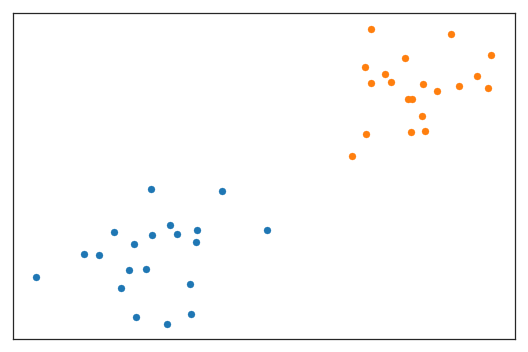

In [6]:
plot_classes(X, y)
plt.show()

Now, fit linear support vector classifiers with different values of the hyperparameter C, which determines the size of the margin. Using a higher C means that the classifier will have a smaller margin, and therefore has fewer margin violations. Using a lower C increases the margin, at the cost of more violations.

Note: our focus here is on the figures themselves, not on the intricate details of the code that generates the plots. 

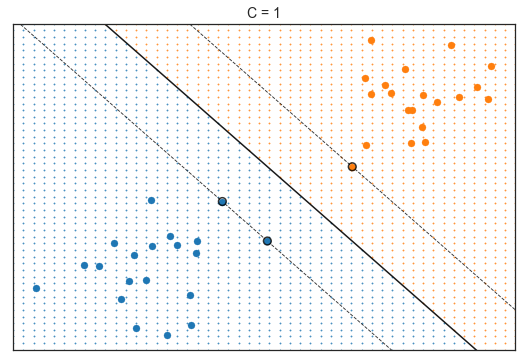

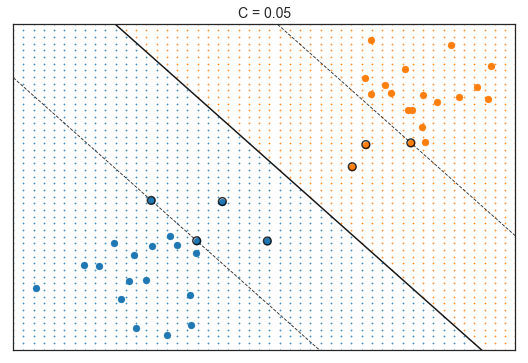

In [7]:
# Plot maximal margin and soft margin classifiers
# Uses snippets from scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html

from sklearn.svm import SVC

for penalty in [1, 0.05]:

    # Fit Support Vector Classifier
    svm = SVC(kernel='linear', C = penalty)
    svm.fit(X, y)

    # Separating line
    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (svm.intercept_[0]) / w[1]

    # Margin lines
    margin = 1 / np.sqrt(np.sum(svm.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin


    # Scatter plot
    fig, ax = plot_classes(X, y)
    a=ax.get_xlim()
    b=ax.get_ylim()

    # Plot separating line and margins
    ax.plot(xx, yy, 'k-', linewidth=1.5, alpha=0.9)
    ax.plot(xx, yy_down, 'k--', linewidth=0.9, alpha=0.8, zorder=-1)
    ax.plot(xx, yy_up, 'k--', linewidth=0.9, alpha=0.8, zorder=-1)

    # Highlight support vectors
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=60, facecolors='none', color='k', 
               alpha=0.8,  linewidth=1.5)
    
    # Plot decision regions
    x1, x2 = np.meshgrid(np.linspace(a[0], a[1], 50), np.linspace(b[0], b[1], 50))
    X_grid = np.c_[x1.reshape(-1,1), x2.reshape(-1,1)]
    y_pred = svm.predict(X_grid)
    ax.scatter(X_grid[y_pred==0, 0], X_grid[y_pred==0, 1], s=2, color=colours[0], alpha=0.8, zorder=-2)
    ax.scatter(X_grid[y_pred==1, 0], X_grid[y_pred==1, 1], s=2, color=colours[1], alpha=0.8, zorder=-2)
    

    ax.set_xlim(a)
    ax.set_ylim(b)
    ax.set_title(f'C = {penalty}', fontsize=14)
    plt.show()

## Illustration: Nonlinear Classification

We now consider the [moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset available from Scikit-Learn to illustrate nonlinear SVM classification. 

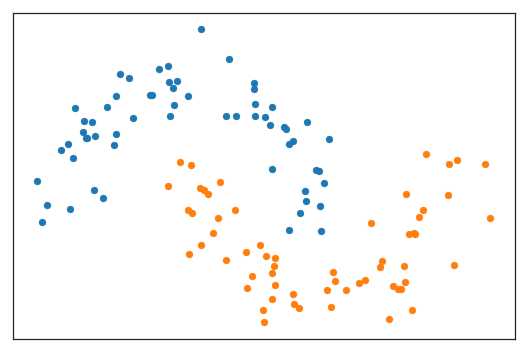

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=120, noise=0.15, random_state=42)

plot_classes(X, y)
plt.show()

In [9]:
def plot_classifier(svm):

    # Scatter plot
    fig, ax = plot_classes(X, y)
    a=ax.get_xlim()
    b=ax.get_ylim()

    # Highlight support vectors
    scaler = StandardScaler().fit(X)
    support_vectors = scaler.inverse_transform(svm._final_estimator.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=60, 
               facecolors='none', color='k', alpha=0.8,  linewidth=1.5)

    # Plot decision regions
    x1, x2 = np.meshgrid(np.linspace(a[0], a[1], 50), np.linspace(b[0], b[1], 50))
    X_grid = np.c_[x1.ravel(), x2.ravel()]
    y_pred = svm.predict(X_grid)
    ax.scatter(X_grid[y_pred==0, 0], X_grid[y_pred==0, 1], s=2, color=colours[0], alpha=0.8, zorder=-2)
    ax.scatter(X_grid[y_pred==1, 0], X_grid[y_pred==1, 1], s=2, color=colours[1], alpha=0.8, zorder=-2)
    
    # Plot decison boundary
    x1, x2 = np.meshgrid(np.linspace(a[0], a[1], 500), np.linspace(b[0], b[1], 500))
    X_grid = np.c_[x1.ravel(), x2.ravel()]
    y_pred = svm.predict(X_grid)
    ax.contour(x1, x2, y_pred.reshape(x1.shape), zorder=-3, colors='k', levels=[0], alpha=0.8)


    ax.set_xlim(a)
    ax.set_ylim(b)
    
    return fig, ax

### Polynomial Kernel

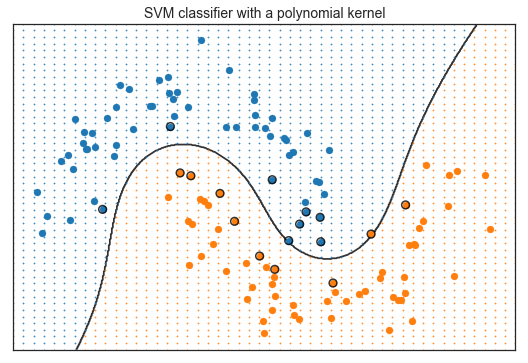

In [10]:
svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
svm.fit(X, y)

fig, ax = plot_classifier(svm)
ax.set_title('SVM classifier with a polynomial kernel', fontsize=14)
plt.show()

### Gaussian RBF Kernel

Increasing $\gamma$ makes the shape of the Gaussian radial basis function become narrower, leading a more irregular decision bounday. Conversely, decreasing $\gamma$ makes the decision boundary more smooth. 

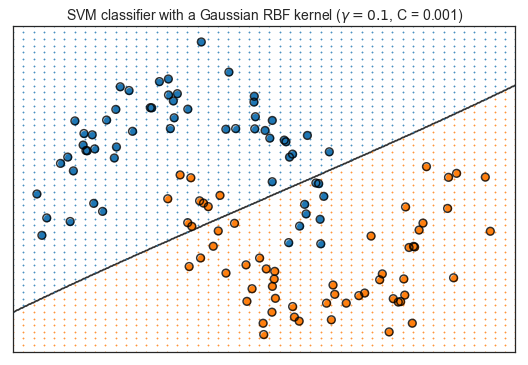

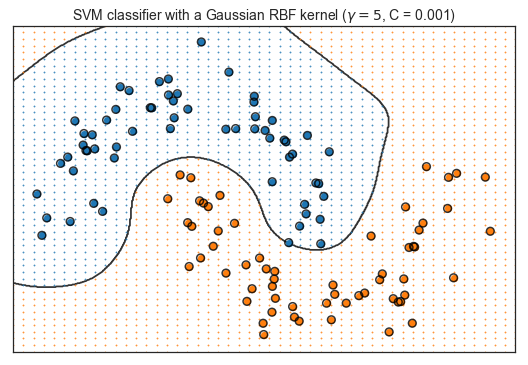

In [11]:
for gamma in [0.1, 5]:
    svm = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=0.001))
        ])
    svm.fit(X, y)

    fig, ax = plot_classifier(svm)
    ax.set_title(f'SVM classifier with a Gaussian RBF kernel ($\gamma = {gamma}$, C = 0.001)', fontsize=14)
    plt.show()

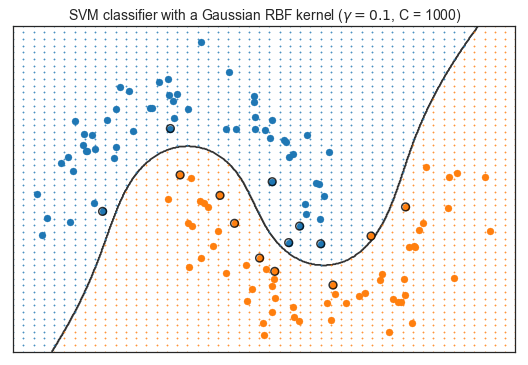

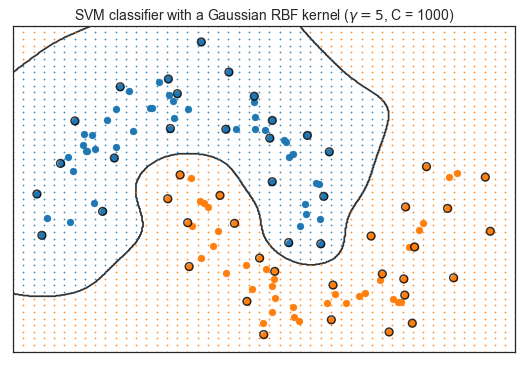

In [12]:
for gamma in [0.1, 5]:
    svm = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=1000))
        ])
    svm.fit(X, y)

    fig, ax = plot_classifier(svm)
    ax.set_title(f'SVM classifier with a Gaussian RBF kernel ($\gamma = {gamma}$, C = 1000)', fontsize=14)
    plt.show()

## Work Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) data available from [Kaggle Datasets](https://www.kaggle.com/datasets).

** Business objective: ** To predict which employees will leave the company.

In [13]:
data = pd.read_csv('Datasets/HR.csv')
data = data.rename(columns = {'sales' : 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [14]:
response='left'
predictors = list(data.columns.values)
predictors.remove(response)

index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.2, random_state=5)

train = data.loc[index_train,].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

## Exploratory Data Analysis

In [15]:
train.describe().round(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,2999.00,2999.00,2999.00,2999.00,2999.00,2999.00,2999.00,2999.00
mean,0.62,0.72,3.79,202.63,3.48,0.14,0.24,0.02
std,0.25,0.17,1.23,49.23,1.41,0.35,0.43,0.14
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.57,3.00,158.00,3.00,0.00,0.00,0.00
50%,0.65,0.73,4.00,202.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


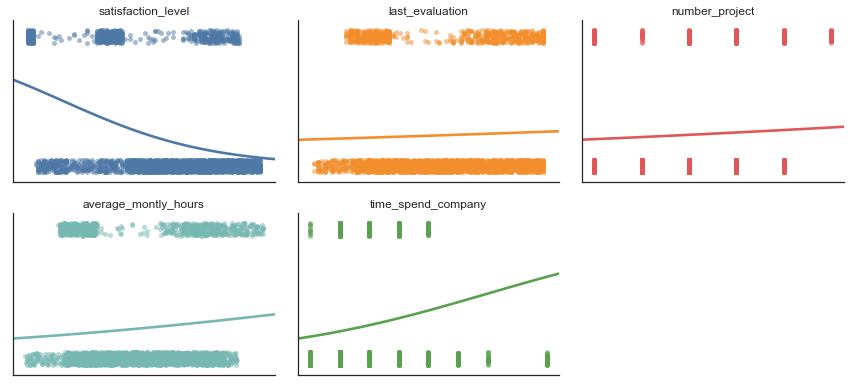

In [16]:
from statlearning import plot_logistic_regressions

with sns.color_palette(crayon):
    plot_logistic_regressions(train[predictors].iloc[:,:5], y_train)
    plt.show()

In [17]:
table=pd.crosstab(y_train, train['promotion_last_5years'])
table = table/table.sum()
table.round(3)

promotion_last_5years,0,1
left,,
0,0.757,0.969
1,0.243,0.031


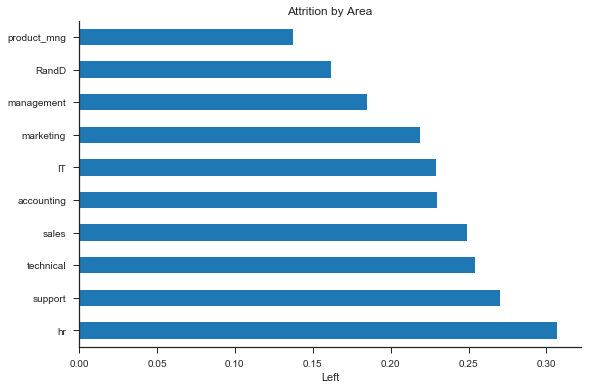

In [18]:
table = (train.groupby('role')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Area')
sns.despine()
plt.show()

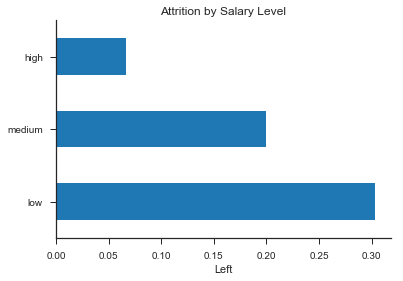

In [19]:
table = (train.groupby('salary')['left'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Salary Level')
sns.despine()
plt.show()

## Data Preparation

Before estimating the models, we need to convert the categorical variables into binary variables. 

In [20]:
dummies = pd.get_dummies(data['role'], drop_first=True)
data = data.join(dummies)
data = data.drop('role', axis= 1)

dummies = pd.get_dummies(data['salary'],  prefix = 'salary', drop_first=True)
data = data.join(dummies)
data = data.drop('salary', axis= 1)

We then update our list of predictors accordingly and construct the train and test design matrices. 

In [21]:
predictors = list(data.columns.values)
predictors.remove(response)

X_train = data.loc[index_train, predictors].copy()
X_test =  data.loc[index_test, predictors].copy()

## Support Vector Machines

### Linear SVC

In [22]:
%%time
# Linear SVC tuning with grid search cross validation
from sklearn.svm import LinearSVC

Cs = list(np.logspace(-15, 15, 31, base=2))

model = Pipeline((
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(loss='hinge')),
))

tuning_parameters ={
    'clf__C': Cs,
}

svm_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
svm_search.fit(X_train, y_train)

svm_linear = svm_search.best_estimator_

print('Best parameter found by randomised search:', svm_search.best_params_, '\n')

Best parameter found by randomised search: {'clf__C': 0.0009765625} 

Wall time: 15.7 s


### Polynomial Kernel

In [23]:
%%time 
# Polynomial kernel SVC tuning with grid search cross validation

Cs = list(np.logspace(-12, 12, 25, base=2))

model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='poly', degree=2, coef0=1.0)),
])


tuning_parameters ={
    'clf__C': Cs,
}

svm_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter = 4, return_train_score=False, n_jobs=4, 
                                random_state = 20)
svm_search.fit(X_train, y_train)

svm_poly = svm_search.best_estimator_

print('Best parameters found by randomised search:', svm_search.best_params_, '\n')

Best parameters found by randomised search: {'clf__C': 1.0} 

Wall time: 1min 20s


### Gaussian RBF Kernel

In [24]:
%%time 
# Gaussian RBF tuning with grid search cross validation

Cs = list(np.logspace(-15, 15, 61, base=2))
gammas = list(np.logspace(-15, 15, 61, base=2))

model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf')),
])


tuning_parameters ={
    'clf__C': Cs,
    'clf__gamma': gammas, 
}

svm_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter = 16, return_train_score=False, n_jobs=4, 
                                random_state = 20)
svm_search.fit(X_train, y_train)

svm_rbf = svm_search.best_estimator_

print('Best parameters found by randomised search:', svm_search.best_params_, '\n')

Best parameters found by randomised search: {'clf__gamma': 0.044194173824159223, 'clf__C': 45.254833995939045} 

Wall time: 17.7 s


## Model Evaluation

We estimate a logistic regression as a benchmark.

In [25]:
logit = LogisticRegression(C=1e5)
logit.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
columns=['Error rate', 'Sensitivity', 'Specificity', 'AUC', 'Precision']
rows=['Logistic regression', 'Linear SVM', 'Polynomial SVM', 'Gaussian RBF SVM']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, svm_linear, svm_poly,  svm_rbf]

y_df = np.zeros((len(test), len(rows)))

for i, method in enumerate(methods):
    
    y_pred = method.predict(X_test)

    confusion  = confusion_matrix(y_test, y_pred)
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,4]=  precision_score(y_test, y_pred)

    y_df[:,i] = method.decision_function(X_test)
    results.iloc[i,3] = roc_auc_score(y_test, y_df[:,i])

results.round(3)

,Error rate,Sensitivity,Specificity,AUC,Precision
Logistic regression,0.225,0.277,0.931,0.822,0.555
Linear SVM,0.228,0.046,0.999,0.784,0.936
Polynomial SVM,0.052,0.904,0.961,0.967,0.879
Gaussian RBF SVM,0.051,0.914,0.960,0.970,0.878


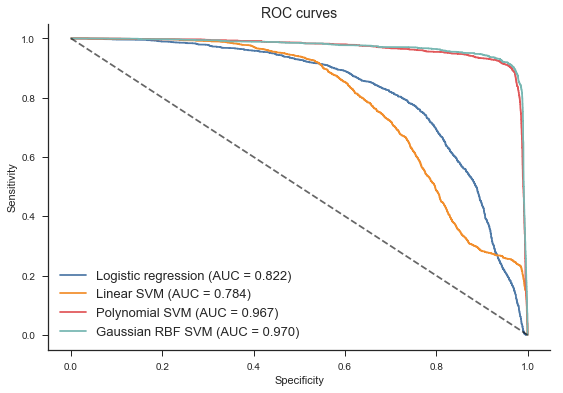

In [27]:
from statlearning import plot_roc_curves

with sns.color_palette(crayon):
    fig, ax = plot_roc_curves(y_test, y_df, labels=pd.Series(rows))
    plt.show()